In [14]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [15]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
full = train.append(test, ignore_index = True);

# Store our passenger ID for easy access
PassengerId = test['PassengerId']
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [16]:
train_y = train.Survived;
print train_y

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, dtype: int64


Standard Process of data, 
1. Create new pd data frame
2. Get Column or row form orginal dataset
3. Apply/map/encode data
4. Append to final result

In [17]:
#Cabin data
tmp_cabin = pd.DataFrame() ##New pada data frame
tmp_cabin['Cabin'] = full['Cabin'].fillna('U')
tmp_cabin['Cabin'] = tmp_cabin['Cabin'].map(lambda x: x[0])
tmp_cabin = pd.get_dummies( tmp_cabin['Cabin'] , prefix = 'Cabin' )
print tmp_cabin.shape
tmp_cabin.head()

(1309, 9)


,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


(891, 1)


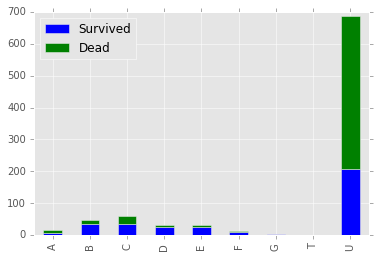

In [18]:
plt_cabin = pd.DataFrame()
plt_cabin['Cabin'] = train['Cabin'].fillna('U')
plt_cabin['Cabin'] = plt_cabin['Cabin'].apply(lambda x:x[0])

print plt_cabin.shape
plt_cabin.head()
plt_cabin['Survived'] = train['Survived']
cs = plt_cabin[plt_cabin['Survived']==1]['Cabin'].value_counts()
cd = plt_cabin[plt_cabin['Survived']==0]['Cabin'].value_counts()

tmp_cabin = pd.DataFrame([cs, cd])
tmp_cabin.index = ['Survived','Dead']
tmp_cabin = tmp_cabin.transpose()
tmp_cabin.plot(kind = 'bar', stacked = True)

In [19]:
tmp_sex = pd.DataFrame()
tmp_sex = full['Sex'].map({'male':1,'female':0})
tmp_sex.shape
tmp_sex.head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

In [20]:
tmp_title = pd.DataFrame()
print full['Name'].head()
print full['Name'].isnull().sum()
tmp_title['Title'] = full['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

Title_Dictionary = {
                    'Capt':       "Officer",
                    'Col':        "Officer",
                    'Major':      "Officer",
                    'Jonkheer':   "Royalty",
                    'Don':        "Royalty",
                    'Sir' :       "Royalty",
                    'Dr':         "Officer",
                    'Rev':        "Officer",
                    'the Countess':"Royalty",
                    'Dona':       "Royalty",
                    'Mme':        "Mrs",
                    'Mlle':       "Miss",
                    'Ms':         "Mrs",
                    'Mr' :        "Mr",
                    'Mrs' :       "Mrs",
                    'Miss' :      "Miss",
                    'Master' :    "Master",
                    'Lady' :      "Royalty"
                    }

tmp_title['Title'] = tmp_title['Title'].map(Title_Dictionary)
tmp_title['Title'].value_counts()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object
0


Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

Miss       129
Mrs        101
Mr          81
Master      23
Officer      5
Royalty      3
Name: Title, dtype: int64
Mr         436
Miss        55
Mrs         26
Master      17
Officer     13
Royalty      2
Name: Title, dtype: int64


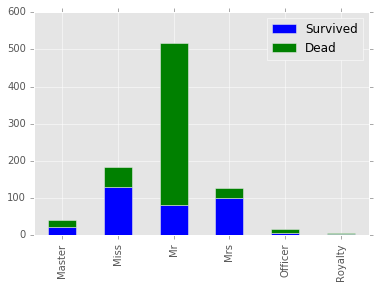

In [21]:
plt_title = tmp_title[0:891]
plt_title['Survived'] = train['Survived']
ts = plt_title[plt_title['Survived'] == 1]['Title'].value_counts()
td = plt_title[plt_title['Survived'] == 0]['Title'].value_counts()
plt_title = pd.DataFrame([ts, td])
print ts
print td
plt_title.index = ['Survived','Dead']
plt_title = plt_title.transpose()
plt_title.plot(kind = 'bar', stacked = True)

In [22]:
tmp_emb = pd.DataFrame()
tmp_emb['Embarked'] = full['Embarked']
tmp_emb = pd.get_dummies( tmp_emb['Embarked'] , prefix = 'Embarked')
tmp_emb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 3 columns):
Embarked_C    1309 non-null float64
Embarked_Q    1309 non-null float64
Embarked_S    1309 non-null float64
dtypes: float64(3)
memory usage: 40.9 KB


S    217
C     93
Q     30
Name: Embarked, dtype: int64
S    427
C     75
Q     47
Name: Embarked, dtype: int64


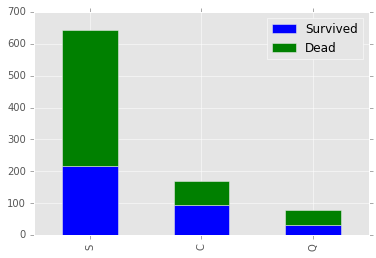

In [23]:
plt_emb = pd.DataFrame()
plt_emb['Embarked'] = train['Embarked']
plt_emb['Survived'] = train['Survived']
plt_emb.head()
emb_s = plt_emb[plt_emb['Survived']==1]['Embarked'].value_counts()
print emb_s

emb_d = plt_emb[plt_emb['Survived']==0]['Embarked'].value_counts()
print emb_d
plt_emb = pd.DataFrame([emb_s, emb_d])
plt_emb.head()
plt_emb.index = ['Survived', 'Dead']
plt_emb = plt_emb.transpose()
plt_emb.plot(kind = 'bar', stacked = True)

It sees that passengers embarked from S have a lower survival rate. 427 dead vs 217 survived.

In [36]:
plt_embg = pd.DataFrame()
plt_embg['Embarked'] = train['Embarked']
plt_embg['Sex'] = train['Sex']
plt_embg['Survived'] = train['Survived']
plt_embg.head()
mes_c = plt_embg[(plt_embg['Sex']=='male') & (plt_embg['Survived'] == 1)]['Embarked'].value_counts()
print mes_c
med_c = plt_embg[(plt_embg['Sex']=='male')&(plt_embg['Survived'] == 0)]['Embarked'].value_counts()
print med_c
fes_c = plt_embg[(plt_embg['Sex']=='female') & (plt_embg['Survived'] == 1)]['Embarked'].value_counts()
print fes_c
fed_c = plt_embg[(plt_embg['Sex']=='female')&(plt_embg['Survived'] == 0)]['Embarked'].value_counts()
print fed_c

m_c = plt_embg[plt_embg['Sex']=='male']['Survived'].value_counts()
f_c = plt_embg[plt_embg['Sex']=='female']['Survived'].value_counts()
print m_c
print f_c
#print me_c
#fe_c = plt_embg[plt_embg['Sex']=='female']['Embarked'].value_counts()
#print fe_c
#plt_embg = pd.DataFrame([fe_c, me_c])
#plt_embg.head()
#plt_embg.index = ['Female', 'Male']
#plt_embg = plt_embg.transpose()
#plt_embg.plot(kind = 'bar', stacked = True)

S    77
C    29
Q     3
Name: Embarked, dtype: int64
S    364
C     66
Q     38
Name: Embarked, dtype: int64
S    140
C     64
Q     27
Name: Embarked, dtype: int64
S    63
C     9
Q     9
Name: Embarked, dtype: int64
0    468
1    109
Name: Survived, dtype: int64
1    233
0     81
Name: Survived, dtype: int64


Infact, more male is a embarked from S than female.